https://www.kaggle.com/markwijkhuizen/preprocessing-oversampling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install -q transformers
from transformers import LongformerTokenizer
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
import glob
import re

tqdm.pandas()

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 61.2 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 6.5 MB 65.9 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# In debug mode a subset of the training dataset is used
DEBUG = False

In [3]:
# Column Data Types
dtype = {
    'id': 'string',
    'discourse_id': np.uint64,
    'discourse_start': np.uint16,
    'discourse_end': np.uint16,
    'discourse_text': 'string',
    'discourse_type': 'category',
    'discourse_type_num': 'category',
    'predictionstring': 'string',
}

if DEBUG:
    train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ori_data/train.csv', dtype=dtype).head(int(10e3))
else:
    train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ori_data/train.csv', dtype=dtype)

display(train.head())

display(train.info())

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144293 entries, 0 to 144292
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  144293 non-null  string  
 1   discourse_id        144293 non-null  uint64  
 2   discourse_start     144293 non-null  uint16  
 3   discourse_end       144293 non-null  uint16  
 4   discourse_text      144293 non-null  string  
 5   discourse_type      144293 non-null  category
 6   discourse_type_num  144293 non-null  category
 7   predictionstring    144293 non-null  string  
dtypes: category(2), string(3), uint16(2), uint64(1)
memory usage: 5.2 MB


None

In [4]:
# Number of Annotated Words, Ignoring Double Annotated Words
def sample_ann_word_count(predictionstrings):
    s = set()
    
    for l in predictionstrings.str.split():
        for e in l:
            s.add(int(e))
        
    return [len(s)] * len(predictionstrings)

# Text Word Count
train['word_count'] = train['discourse_text'].apply(word_tokenize).apply(len).astype(np.uint16)

# Text Word Count
train['ann_word_count'] = train['predictionstring'].str.split(' ').apply(len).astype(np.uint16)

# Sample Word Count
train['sample_ann_word_count'] = train.groupby('id')['predictionstring'].transform(sample_ann_word_count).astype(np.uint16)

# Text Sentence Count
train['sentence_count'] = train['discourse_text'].apply(sent_tokenize).apply(len).astype(np.uint16)

# Maximum Word Index
train['max_word_index'] = train['predictionstring'].str.split(' ').apply(lambda l: int(l[-1])).astype(np.uint16)

# Max Word Index of Text ID
train['sample_max_word_index'] = train.groupby('id')['max_word_index'].transform('max')

In [5]:
# Text ID to Word Count
def id2sample_word_count(text_ids):
    text_id = text_ids.values[0]
    # Read Text File
    with open(f'/content/drive/MyDrive/Colab Notebooks/ori_data/train/{text_id}.txt', 'r') as f:
        text = f.read().split()
        word_count = len(text)
        
    return [word_count] * len(text_ids)

In [6]:
# Sample Word Count
train['sample_word_count'] = train.groupby('id')['id'].transform(id2sample_word_count).astype(np.uint16)

# Ratio of Annotated Words
train['ann_ratio'] = (train['sample_ann_word_count'] / train['sample_word_count']).astype(np.float32)

In [7]:
display(train.head(10))

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,word_count,ann_word_count,sample_ann_word_count,sentence_count,max_word_index,sample_max_word_index,sample_word_count,ann_ratio
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,47,44,378,3,44,378,379,0.997361
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,16,15,378,1,59,378,379,0.997361
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,17,16,378,1,75,378,379,0.997361
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,68,63,378,4,138,378,379,0.997361
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,27,24,378,3,162,378,379,0.997361
5,423A1CA112E2,1622627780655,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...,58,48,378,4,210,378,379,0.997361
6,423A1CA112E2,1622627811787,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...,81,71,378,5,281,378,379,0.997361
7,423A1CA112E2,1622627585180,1534,1602,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...,17,15,378,1,296,378,379,0.997361
8,423A1CA112E2,1622627895668,1603,1890,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...,65,58,378,3,354,378,379,0.997361
9,423A1CA112E2,1622627628524,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...,26,24,378,2,378,378,379,0.997361


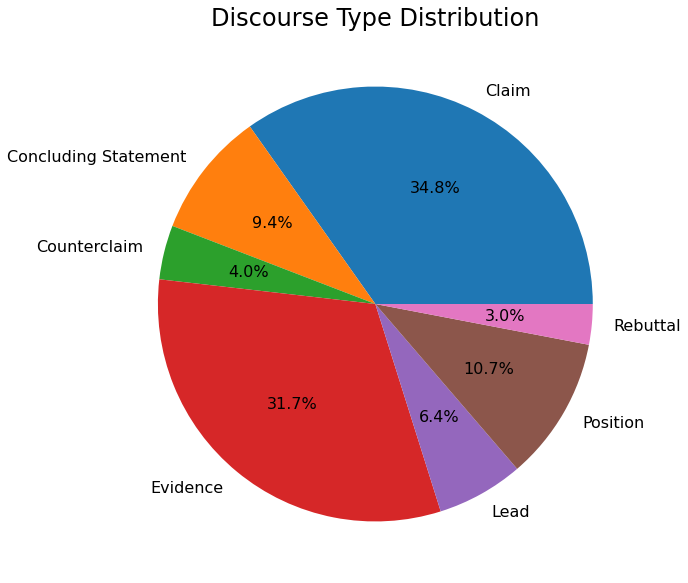

In [8]:
# Discourse Type Distribution
plt.figure(figsize=(10,10))
train.groupby('discourse_type')['discourse_type'].count().plot(kind='pie', autopct='%1.1f%%', textprops={'fontsize': 16}, startangle=0)
plt.title('Discourse Type Distribution', size=24)
plt.ylabel('')
pass

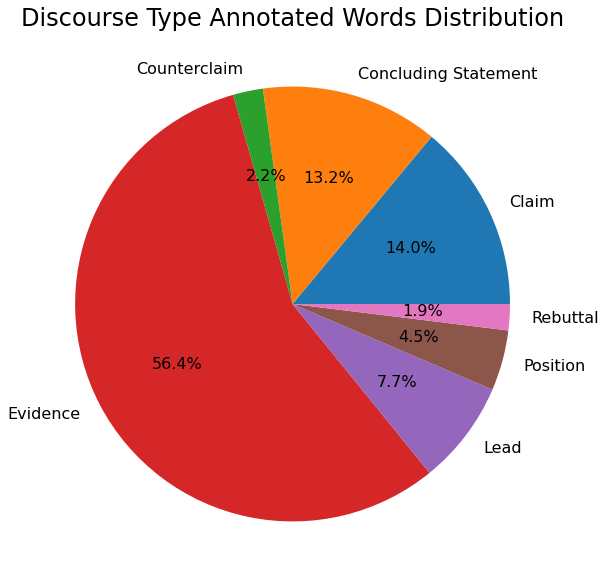

In [9]:
# Discourse Type Distribution
plt.figure(figsize=(10,10))
train.groupby('discourse_type')['ann_word_count'].sum().plot(kind='pie', autopct='%1.1f%%', textprops={'fontsize': 16}, startangle=0)
plt.title('Discourse Type Annotated Words Distribution', size=24)
plt.ylabel('')
pass

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 7 Text major ticklabel objects>)

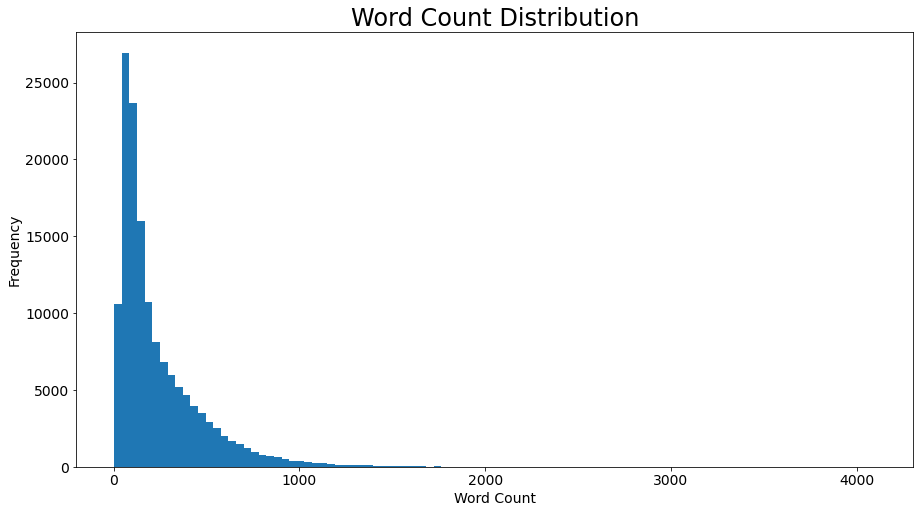

In [42]:
train["discourse_len"] = train["discourse_end"] - train["discourse_start"]

plt.figure(figsize=(15, 8))
train['discourse_len'].plot(kind='hist', bins=100)
plt.title('Word Count Distribution', size=24)
plt.xlabel('Word Count', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(size=14)
plt.yticks(size=14)

In [10]:
# The annotated word count inbalance can be explained by the difference in discourse type size
display(train.groupby(['discourse_type'])['ann_word_count'].describe())

,count,mean,std,min,25%,50%,75%,max
discourse_type,,,,,,,,
Claim,50208.0,17.423359,10.518978,1.0,10.0,16.0,23.0,146.0
Concluding Statement,13505.0,61.301148,34.769977,2.0,36.0,56.0,80.0,440.0
Counterclaim,5817.0,24.037476,16.091799,1.0,14.0,20.0,29.0,215.0
Evidence,45702.0,77.366680,52.454848,2.0,41.0,66.0,100.0,836.0
Lead,9305.0,51.949704,35.187840,1.0,27.0,45.0,69.0,542.0
Position,15419.0,18.247681,10.672725,1.0,11.0,16.0,23.0,141.0
Rebuttal,4337.0,28.093844,20.563402,2.0,14.0,23.0,36.0,279.0


1534
Index(['id', 'discourse_id', 'discourse_start', 'discourse_end',
       'discourse_text', 'discourse_type', 'discourse_type_num',
       'predictionstring', 'word_count', 'ann_word_count',
       'sample_ann_word_count', 'sentence_count', 'max_word_index',
       'sample_max_word_index', 'sample_word_count', 'ann_ratio'],
      dtype='object')
1534


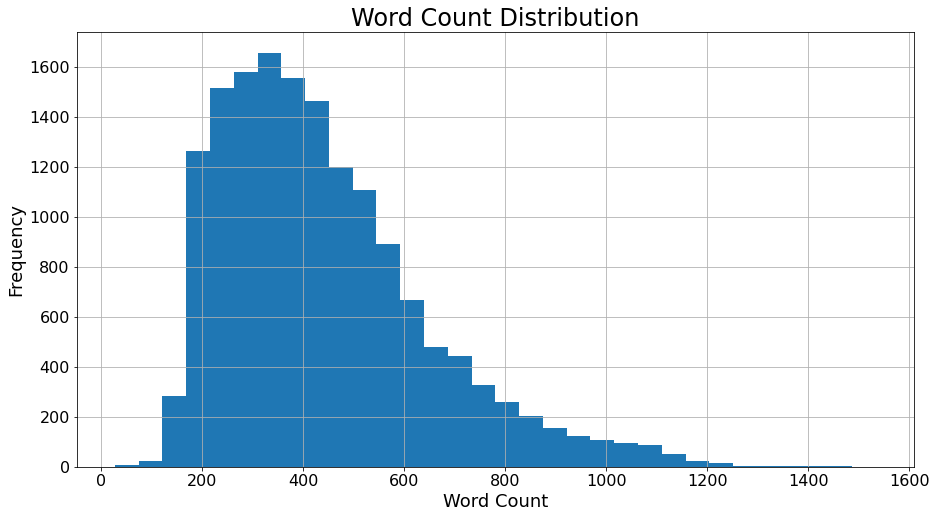

In [21]:
# Word Count Distribution
plt.figure(figsize=(15, 8))
train.groupby('id')['word_count'].sum().plot(kind='hist', bins=32)
print(max(train.groupby('id')['word_count'].sum()))
print(train.keys())
a = train.groupby('id')['word_count']
print(max(a.sum()))
plt.title('Word Count Distribution', size=24)
plt.xlabel('Word Count', size=18)
plt.ylabel('Frequency', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid()
pass

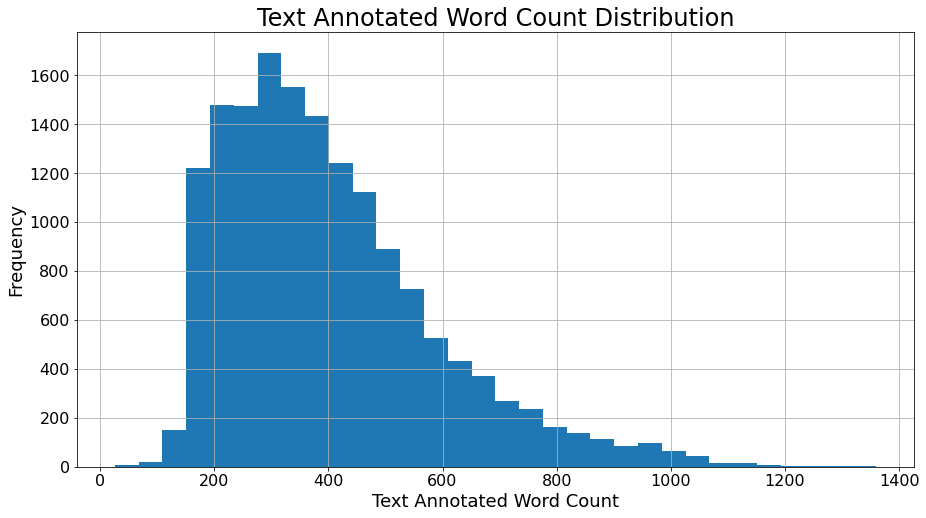

In [ ]:
# Word Count Distribution
plt.figure(figsize=(15, 8))
train.groupby('id')['ann_word_count'].sum().plot(kind='hist', bins=32)
plt.title('Text Annotated Word Count Distribution', size=24)
plt.xlabel('Text Annotated Word Count', size=18)
plt.ylabel('Frequency', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid()
pass

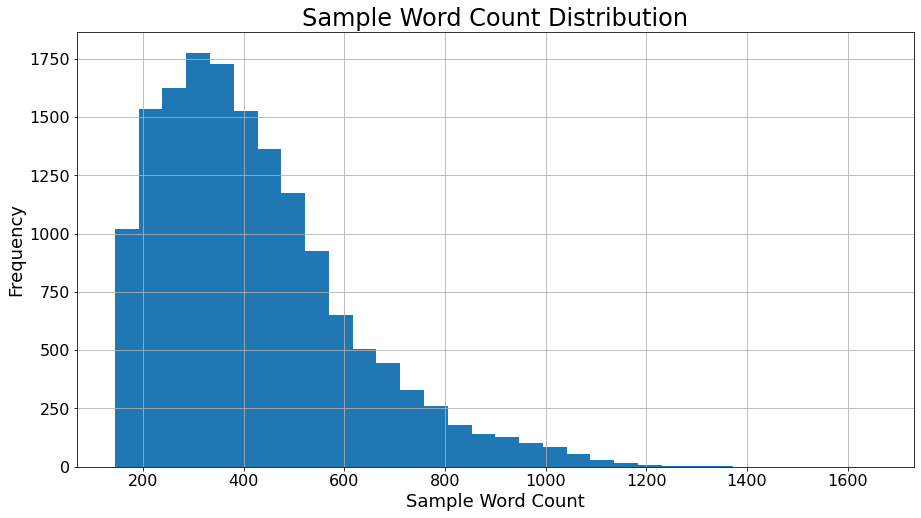

In [38]:
# Word Count Distribution
plt.figure(figsize=(15, 8))
train.groupby('id')['sample_word_count'].first().plot(kind='hist', bins=32)
plt.title('Sample Word Count Distribution', size=24)
plt.xlabel('Sample Word Count', size=18)
plt.ylabel('Frequency', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid()
pass

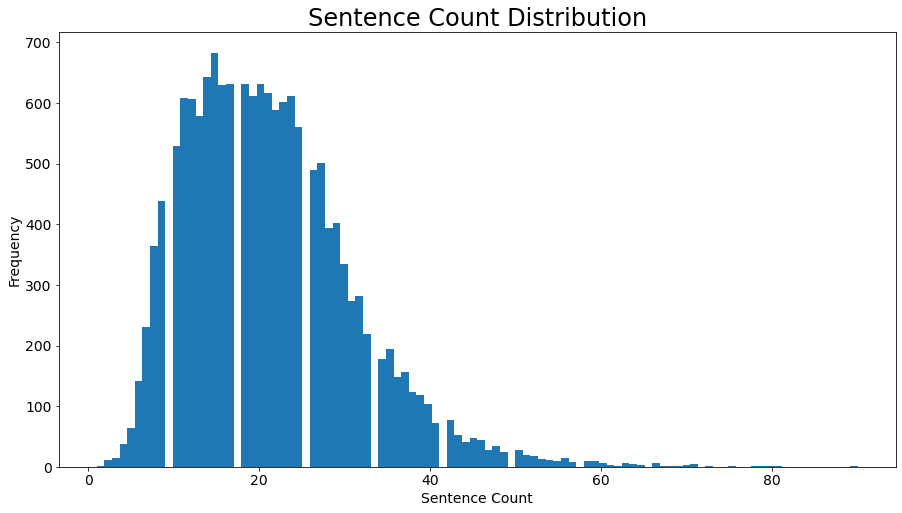

In [43]:
# Word Count Distribution
plt.figure(figsize=(15, 8))
train.groupby('id')['sentence_count'].sum().plot(kind='hist', bins=100)
plt.title('Sentence Count Distribution', size=24)
plt.xlabel('Sentence Count', size=14)
plt.ylabel('Frequency', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
pass

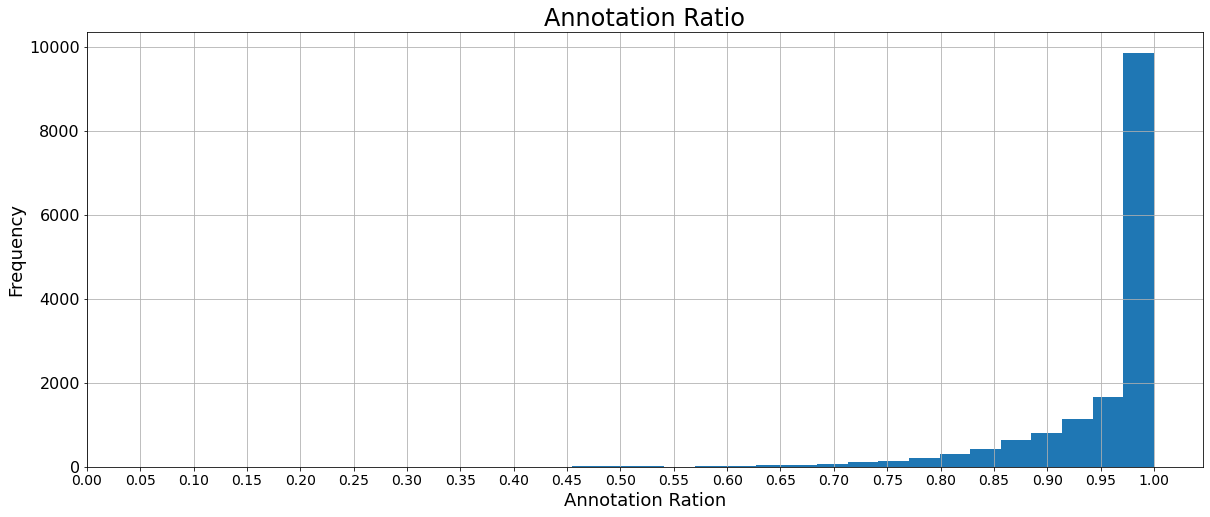

In [ ]:
# Annotation Ratio Distribution
plt.figure(figsize=(20, 8))
train.groupby('id')['ann_ratio'].first().plot(kind='hist', bins=32)
plt.title('Annotation Ratio', size=24)
plt.xlabel('Annotation Ration', size=18)
plt.ylabel('Frequency', size=18)
plt.xticks([i * 0.05 for i in range(21)], size=14)
plt.yticks(size=16)
plt.grid()
pass